# Antes de empezar

**Si no estas trabajando en un entorno de trabajo, crearlo:**  

\$ conda create -n chipExercise python=3.6.2 anaconda  
\$ source activate chipExercise  
\$ conda config --add channels conda-forge

**Instalar todas las librerias necesarias**  

\$ conda install jupyter  
\$ conda install jupyterlab  
\$ conda install matplotlib  
\$ conda install cycler  
\$ jupyter-lab ejercicio.ipynb 

In [1]:
%load_ext autoreload
%autoreload 2

# Importo dataset

In [2]:
import numpy as np
from sklearn.preprocessing import StandardScaler

X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')
y_train = np.load('y_train.npy') 
y_test = np.load('y_test.npy')

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# No olvidar instalar Keras:
\$ conda install keras

In [3]:
from keras.models import Sequential
from keras import optimizers
from keras.layers.core import Dense, Activation
from helper import PlotLosses
from keras.callbacks import ModelCheckpoint
from keras.initializers import RandomNormal

Using TensorFlow backend.
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Parametros del modelo

In [196]:
# Paramtros fijos
input_shape = 2 # Tenemos solo 2 features
output_size = 1 # Solo tenemos 2 clases

# Parametros a modificar
hidden_units = 10 # Tratar de encontrar un tamaño optimo para el test set

# Probar distintos initializers
# kernel_initializer = 'zeros'
kernel_initializer = RandomNormal(mean=0.0, stddev=0.1, seed=None)

# Armo red neuronal
Cada vez que se cambia un parametro, ejecutar desde aca

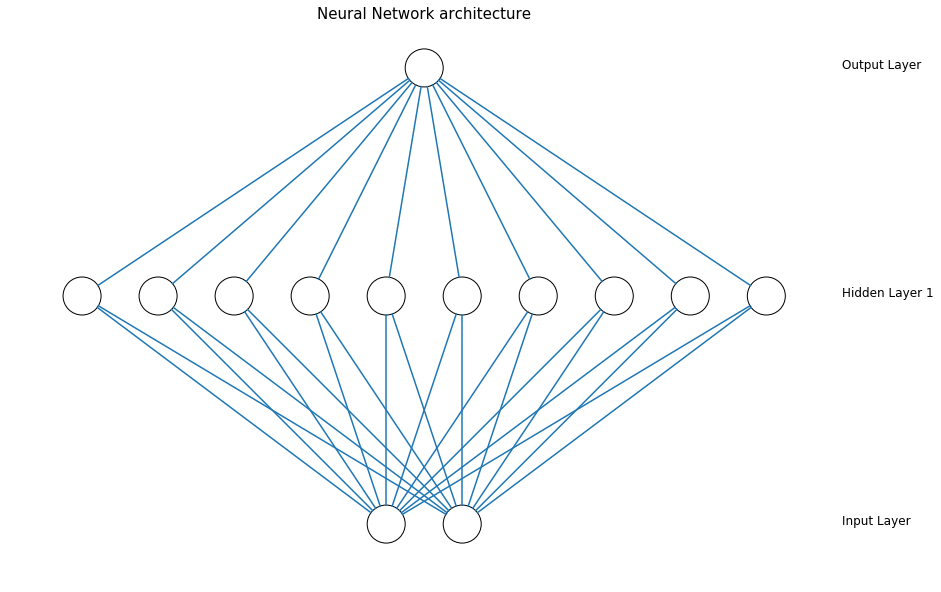

In [197]:
import draw_nn
network = draw_nn.DrawNN( [input_shape, hidden_units, output_size] )
network.draw()

In [198]:
model = Sequential()
model.add(Dense(hidden_units,input_dim=input_shape))
model.add(Activation('sigmoid'))
model.add(Dense(output_size, kernel_initializer=kernel_initializer))
model.add(Activation('sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 10)                30        
_________________________________________________________________
activation_41 (Activation)   (None, 10)                0         
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 11        
_________________________________________________________________
activation_42 (Activation)   (None, 1)                 0         
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


# Compilo y Entreno el modelo

In [199]:
# Para SGD lr=2 funciona ok pero muy lento: 40.000 epochs acc 1 (decay = 0) (20 hidden units)
# Para adam 0.4, decay = 0.002 converge enseguida (20 hidden units)
# Correrlo mas de una vez con los mismos parametros y verificar los resultados
lr = 0.01 # Modificarlo y ver que ocurre.
decay = 0.005 # Modificarlo y ver que ocurre
batch_size = 59 # 59 es el tamaño del train set. Seria hacer GD, en 1 seria SGD. Probar valores intermedios tambien
epochs = 2500

# Elejir uno de estos dos optimizadores. O buscar documentación y probar algun otro
# selectedOptimizer = optimizers.SGD(lr=lr, decay=decay)
selectedOptimizer = optimizers.adam(lr=lr, decay=decay)
# selectedOptimizer = optimizers.RMSprop(lr=lr, decay=decay)
# selectedOptimizer = optimizers.Nadam(lr=lr, schedule_decay=decay)

# Lo compilo
model.compile(loss = 'binary_crossentropy', optimizer=selectedOptimizer, metrics=['accuracy'])

In [200]:
# Se puede tocar plot_interval para acelerar el proceso, el resto recomendamos no tocarlo
plot_losses = PlotLosses(plot_interval=100, 
                         evaluate_interval=None, 
                         x_val=X_test, 
                         y_val_categorical=y_test)

In [201]:
checkpointer = ModelCheckpoint(filepath='two_layer_model_best.hdf5', verbose=0, save_best_only=True)

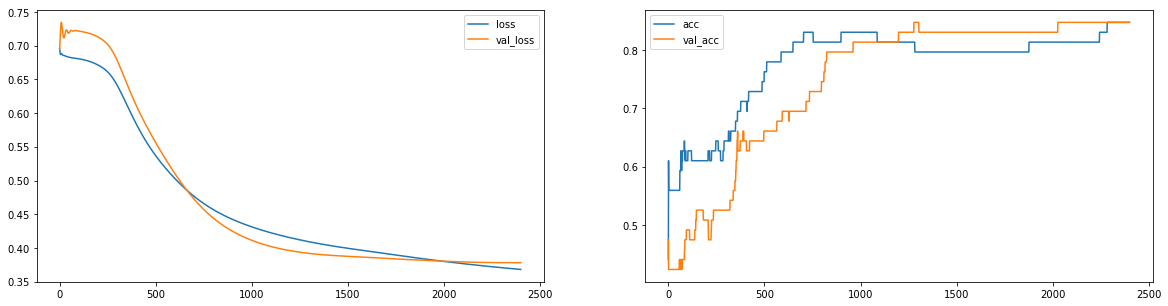

In [202]:
model.fit(X_train, 
          y_train, batch_size = batch_size,
          epochs=epochs, 
          verbose=0, 
          validation_data=(X_test, y_test), 
          callbacks=[plot_losses, checkpointer],
         )

In [203]:
model.save_weights('two_layer_model_last.hdf5')

# Grafico resultado al final del entrenamiento

209152/210216 [============================>.] - ETA: 0s   

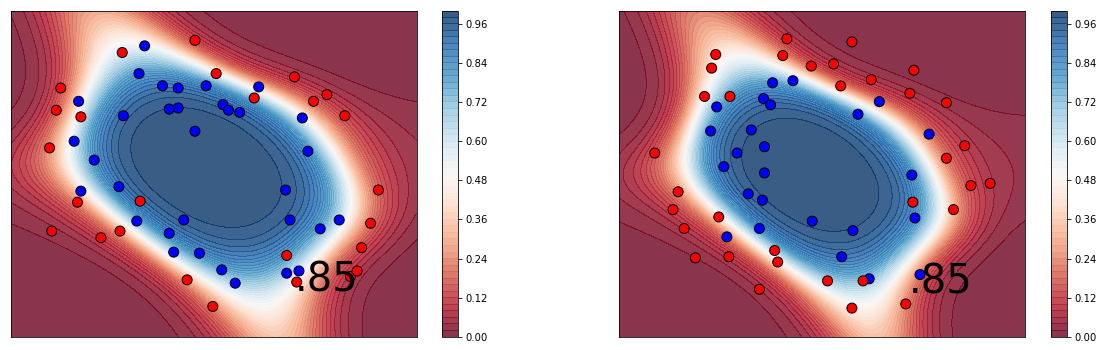

In [204]:
model.load_weights('two_layer_model_last.hdf5')
from helper import plot_boundaries_keras
from matplotlib import pyplot as plt

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
plot_boundaries_keras(X_train, y_train, model.evaluate(X_train, y_train)[1], model.predict_proba, h = 0.005, margin=0.2, ax=ax1)
plot_boundaries_keras(X_test, y_test, model.evaluate(X_test, y_test)[1], model.predict_proba, h = 0.005, margin=0.2, ax=ax2)
plt.show()

# Grafico mejor resultado guardado con el Checkpointer

In [ ]:
# Cargo pesos
model.load_weights('two_layer_model_best.hdf5')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
plot_boundaries_keras(X_train, y_train, model.evaluate(X_train, y_train)[1], model.predict_proba, h = 0.005, margin=0.1, ax=ax1)
plot_boundaries_keras(X_test, y_test, model.evaluate(X_test, y_test)[1], model.predict_proba, h = 0.005, margin=0.1, ax=ax2)
plt.show()

# Comparo los pesos de ambos resultados

In [ ]:
model.load_weights('two_layer_model_best.hdf5')
best_weights = model.get_weights()
model.load_weights('two_layer_model_last.hdf5')
last_weights = model.get_weights()

for i,layer_weights in enumerate(best_weights):
    print('mean:', layer_weights.mean(), layer_weights.shape, last_weights[i].mean())
    print('STD:', layer_weights.std(), layer_weights.shape, last_weights[i].std())
    print('MAX:', np.max(abs(layer_weights)), layer_weights.shape, np.max(abs(last_weights[i])))
    print()